# Sentiment Classification Using RNNs

* Given the IMDB Movie Review Dataset, create an RNN model that predicts whether the given review is negative or positive.
* You need to create your Dataset, Dataloader and Model. Keep your code modular and avoid hardcoding any parameter. This will allow you to experiment more easily.
* Plot graphs for loss and accuracy for each epoch of a training loop. Try using wandb for logging training and validation losses, accuracies.
* Use tqdm to keep track of the status of the training loop for an epoch

### 1. RNN Model
#### 1.1 Build a Dataset from the IMDB Movie Review Dataset by taking reviews with word count between 100 and 500. Perform text processing on the movie reviews and create a word to index mapping for representing any review as a list of numbers.
#### 1.2 Create Dataloaders for the train, test and validation datasets with appropriate batch sizes.
#### 1.3 Create the Model class for the RNN Model. Create functions for running model training and testing.

In [2]:
!pip install datasets torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━

In [3]:
import numpy as np
import nltk
import matplotlib.pyplot as plt

from datasets import load_dataset
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy

from tqdm import tqdm

In [4]:
SEED = 1234

# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [6]:
# load the IMDB review dataset. You can take the dataset from Huggingface
imdb_dataset = load_dataset("imdb")


train_dataset = imdb_dataset["train"]
test_dataset = imdb_dataset["test"]

print(len(train_dataset))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

25000


In [7]:
from nltk.tokenize import RegexpTokenizer
import re

def preprocess_text(text, custom_tokenizer):
    # Replace any sequence of digits with a placeholder token
    text = re.sub(r'\b\d+\b', 'num_token', text)

    # Convert all characters to lowercase
    text = text.lower()

    # Tokenize the sentence into words
    tokens = custom_tokenizer.tokenize(text)

    return tokens

# Example usage:
custom_tokenizer = RegexpTokenizer(r'\w+')
text = "This is a 123 test sentence."
processed_text = preprocess_text(text, custom_tokenizer)
print(processed_text)


['this', 'is', 'a', 'num_token', 'test', 'sentence']


In [8]:
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, custom_tokenizer):
    # Replace all numeric sequences with a placeholder token 'num'
    text = re.sub(r'\b\d+\b', 'num', text)

    # Convert the text to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = custom_tokenizer.tokenize(text)

    # Lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return lemmatized_tokens

# Example usage:
custom_tokenizer = RegexpTokenizer(r'\w+')
text = "This is a 123 test sentence."
processed_text = preprocess_text(text, custom_tokenizer)
print(processed_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


['this', 'is', 'a', 'num', 'test', 'sentence']


In [9]:
preprocess_text("This IS 1 example sentence", RegexpTokenizer(r'\w+'))

['this', 'is', 'num', 'example', 'sentence']

In [10]:
from collections import defaultdict

def create_word_to_index(corpus, tokenizer, min_length=100, max_length=500):
    # Initialize the word-to-index dictionary
    word_to_index = defaultdict(int)
    index = 1  # Start index with 1 (0 for padding)

    # Iterate through each sentence in the corpus
    for sentence in tqdm(corpus, total=len(corpus), desc="Creating word-to-index dictionary"):
        # Process the sentence
        words = preprocess_text(sentence, tokenizer)

        # Calculate the word count of the sentence
        word_count = len(words)

        # Skip sentences with word count not within the specified range
        if word_count < min_length or word_count > max_length:
            continue

        # Iterate through each word in the sentence
        for word in words:
            # Check if the word already exists in the word-to-index dictionary
            if word not in word_to_index:
                # Assign a unique index to the word
                word_to_index[word] = index
                index += 1  # Increment index for the next new word

    return index, word_to_index


In [11]:
tokenizer = RegexpTokenizer(r'\w+')
idx,word_to_index = create_word_to_index(imdb_dataset['train']['text'],tokenizer)


Creating word-to-index dictionary: 100%|██████████| 25000/25000 [00:23<00:00, 1063.73it/s]


In [12]:
print(idx)

57484


In [13]:
imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [14]:
from sklearn.model_selection import train_test_split
from datasets import DatasetDict

# Extract samples with positive and negative sentiment labels
pos_samples = [sample for sample in imdb_dataset['train'] if sample['label'] == 1]
neg_samples = [sample for sample in imdb_dataset['train'] if sample['label'] == 0]

# Split positive samples into training and validation sets
positive_train, positive_val = train_test_split(pos_samples, test_size=0.2, stratify=[sample['label'] for sample in pos_samples])

# Split negative samples into training and validation sets
negative_train, negative_val = train_test_split(neg_samples, test_size=0.2, stratify=[sample['label'] for sample in neg_samples])

# Merge training and validation sets for each sentiment label
train_data = positive_train + negative_train
val_data = positive_val + negative_val

# Create a DatasetDict object to organize training and validation data
new_dataset_dict = DatasetDict({
    'train': train_data,
    'validation': val_data
})


In [15]:
len(new_dataset_dict['validation'])

5000

In [16]:
class CustomDataset(Dataset):
    def __init__(self, dataset_dict, split: str, min_length: int = 100, max_length: int = 500):
        self.count = 0  # Total sentences processed
        self.max_length = max_length

        input_data = []
        target_data = []

        # Retrieve the specified split from the DatasetDict
        dataset_split = dataset_dict[split]

        # Iterate through each sentence in the specified split
        for idx, sample in tqdm(enumerate(dataset_split), total=len(dataset_split), desc=f"Transforming input text [{split}]"):
            sentence = sample['text']  # Extract the text from the sample
            label = sample['label']  # Extract the label from the sample

            # Drop sentences greater than max_length or less than min_length
            if len(sentence) > max_length or len(sentence) < min_length:
                continue

            # Replace words with their index
            indexed_sentence = [word_to_index[word] for word in sentence if word in word_to_index]

            # Add the processed sentence and its label to the dataset
            input_data.append(torch.tensor(indexed_sentence))
            target_data.append(label)

            self.count += 1

        # Pad the sentences up to max_length
        self.inputs = pad_sequence(input_data, batch_first=True)
        self.targets = torch.tensor(target_data)

    def __len__(self) -> int:
        return self.count

    def __getitem__(self, index: int):
        return self.inputs[index], self.targets[index]


In [17]:
print(imdb_dataset['train']['text'][0])

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

In [18]:
# create the train dataset using the word2idx dictionary built using the train set
train_ds = CustomDataset(new_dataset_dict, "train",min_length = 100, max_length = 500)

# create the validation and test dataset using the word2idx dictionary built using the train set
val_ds = CustomDataset(new_dataset_dict, "validation", min_length=100, max_length=500)

# Create the test dataset using the word2idx dictionary built using the train set
test_ds = CustomDataset(imdb_dataset, "test", min_length=100, max_length=500)



Transforming input text [test]: 100%|██████████| 25000/25000 [00:00<00:00, 28518.11it/s]


In [19]:
len(train_ds), len(test_ds) , len(val_ds)

(1934, 2550, 479)

In [20]:
params = {
    'batch_size': 32,
    'shuffle': True,
    'num_workers': 2
}

# Create data loaders
train_dataloader = DataLoader(train_ds, **params)
val_dataloader = DataLoader(val_ds, **params)
test_dataloader = DataLoader(test_ds, **params)


  **1.3->Using the last output**

In [21]:
import torch
import torch.nn as nn

class CustomRNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(CustomRNNModel, self).__init__()

        # Define the layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        # X shape: (batch_size, seq_len)
        embedded = self.embedding(X)  # Embedding layer
        output, _ = self.rnn(embedded)  # RNN layer
        # output shape: (batch_size, seq_len, hidden_size)

        # Apply fully connected layer to the last time step
        logits = self.fc(output[:, -1, :])  # Only take the output of the last time step
        # logits shape: (batch_size, num_classes)

        return logits


In [22]:
vocab_size = 57484
num_classes = 2
# Hyperparameters
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5

# Create the model
model = CustomRNNModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)

CustomRNNModel(
  (embedding): Embedding(57484, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [23]:
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, epochs, device):
    train_losses = []
    val_losses = []
    val_accuracy = []

    best_val_loss = float('inf')
    best_model = None

    for epoch in range(1, epochs + 1):
        train_loss = 0.0
        val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        # Training Step
        model.train()
        for input_batch, target_batch in tqdm(train_dataloader, total=len(train_dataloader), desc="Training"):
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            optimizer.zero_grad()
            output = model(input_batch)
            loss = criterion(output, target_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * input_batch.size(0)

        train_loss /= len(train_dataloader.dataset)
        train_losses.append(train_loss)

        # Validation Step
        model.eval()
        with torch.no_grad():
            for input_batch, target_batch in tqdm(val_dataloader, total=len(val_dataloader), desc="Validation"):
                input_batch, target_batch = input_batch.to(device), target_batch.to(device)

                output = model(input_batch)
                loss = criterion(output, target_batch)
                val_loss += loss.item() * input_batch.size(0)

                _, predicted = torch.max(output, 1)
                correct_predictions += (predicted == target_batch).sum().item()
                total_predictions += target_batch.size(0)

        val_loss /= len(val_dataloader.dataset)
        val_losses.append(val_loss)

        accuracy = correct_predictions / total_predictions
        val_accuracy.append(accuracy)

        print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.4f}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

    return train_losses, val_losses, val_accuracy, best_model


In [24]:
def evaluate_model(model, test_dataloader, criterion, device):
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    model.eval()
    with torch.no_grad():
        for input_batch, target_batch in tqdm(test_dataloader, total=len(test_dataloader), desc="Testing"):
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            output = model(input_batch)
            loss = criterion(output, target_batch)
            test_loss += loss.item() * input_batch.size(0)

            _, predicted = torch.max(output, 1)
            correct_predictions += (predicted == target_batch).sum().item()
            total_predictions += target_batch.size(0)

    test_loss /= len(test_dataloader.dataset)
    accuracy = correct_predictions / total_predictions

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    return test_loss, accuracy


In [25]:
# train the model
# Define loss criterion
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses, val_accuracy,best_model = train_model(model, train_dataloader, val_dataloader, optimizer, criterion, epochs, device)

Validation: 100%|██████████| 15/15 [00:00<00:00, 40.94it/s]


Epoch 1/5, Train Loss: 0.6975, Val Loss: 0.6930, Val Accuracy: 0.5470


Validation: 100%|██████████| 15/15 [00:00<00:00, 93.61it/s] 


Epoch 2/5, Train Loss: 0.6881, Val Loss: 0.6944, Val Accuracy: 0.5470


Validation: 100%|██████████| 15/15 [00:00<00:00, 100.10it/s]


Epoch 3/5, Train Loss: 0.7137, Val Loss: 0.6929, Val Accuracy: 0.5449


Validation: 100%|██████████| 15/15 [00:00<00:00, 96.26it/s]


Epoch 4/5, Train Loss: 0.7048, Val Loss: 0.6883, Val Accuracy: 0.5491


Validation: 100%|██████████| 15/15 [00:00<00:00, 97.87it/s] 

Epoch 5/5, Train Loss: 0.6913, Val Loss: 0.6891, Val Accuracy: 0.5470


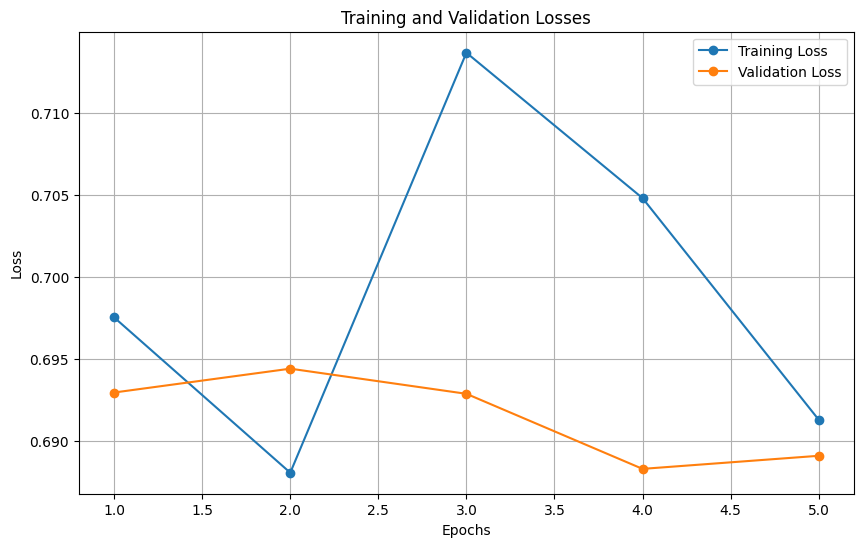

In [26]:
# plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

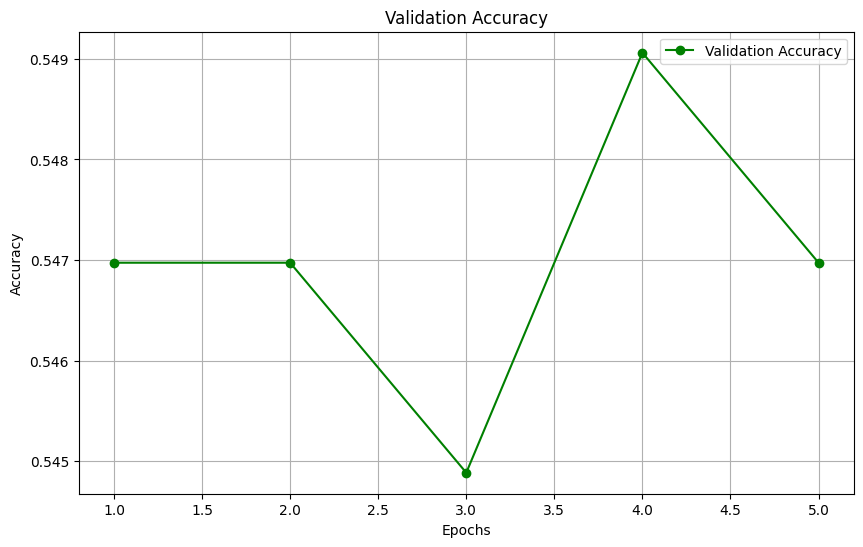

In [27]:
# plot validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), val_accuracy, label='Validation Accuracy', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# find the classification accuracy on test set
# Define the loss criterion for testing
test_criterion = nn.CrossEntropyLoss()

# Test the model on the test set
test_loss, test_accuracy = evaluate_model(model, test_dataloader, test_criterion, device)

print(f"Test Accuracy: {test_accuracy:.8f}")


Testing: 100%|██████████| 80/80 [00:00<00:00, 186.33it/s]

Test Loss: 0.6905, Test Accuracy: 0.5408
Test Accuracy: 0.54078431


#### 1.2 Incorporate stemming/lemmatization when doing text preprocessing using the NLTK library. What changes do you observe in accuracy ?

In [29]:
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')

# Initialize lemmatizer
word_lemmatizer = WordNetLemmatizer()

def preprocess_text(text, custom_tokenizer):
    # Replace numbers with a placeholder 'num'
    text = re.sub(r'\b\d+\b', 'num', text)

    # Convert text to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = custom_tokenizer.tokenize(text)

    # Lemmatize each token
    lemmatized_tokens = [word_lemmatizer.lemmatize(token) for token in tokens]

    return lemmatized_tokens


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
# Test
sample_text = "The boys are playing in 232 garden street london."
tokenizer = RegexpTokenizer(r'\w+')
cleaned_text = preprocess_text(sample_text, tokenizer)
print("Original text:")
print(sample_text)
print("\nCleaned tokens:")
print(cleaned_text)

Original text:
The boys are playing in 232 garden street london.

Cleaned tokens:
['the', 'boy', 'are', 'playing', 'in', 'num', 'garden', 'street', 'london']


In [31]:
idx,word2idx = create_word_to_index(imdb_dataset['train']['text'],tokenizer)

Creating word-to-index dictionary: 100%|██████████| 25000/25000 [00:23<00:00, 1066.95it/s]


In [32]:
print(idx)

57484


In [33]:
# create the train dataset using the word2idx dictionary built using the train set
train_ds = CustomDataset(new_dataset_dict, "train",min_length = 100, max_length = 500)


# create the validation and test dataset using the word2idx dictionary built using the train set
val_ds = CustomDataset(new_dataset_dict, "validation", min_length=100, max_length=500)

# Create the test dataset using the word2idx dictionary built using the train set
test_ds = CustomDataset(imdb_dataset, "test", min_length=100, max_length=500)


Transforming input text [test]: 100%|██████████| 25000/25000 [00:00<00:00, 28936.80it/s]


In [34]:
params = {
    'batch_size': 32,
    'shuffle': True,
    'num_workers': 2
}

# Create data loaders
train_dataloader = DataLoader(train_ds, **params)
val_dataloader = DataLoader(val_ds, **params)
test_dataloader = DataLoader(test_ds, **params)

In [35]:
vocab_size = 57484
num_classes = 2
# Hyperparameters
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5

# Create the model
model = CustomRNNModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)

CustomRNNModel(
  (embedding): Embedding(57484, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [36]:
# train the model
# Define loss criterion
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses, val_accuracy,best_model = train_model(model, train_dataloader, val_dataloader, optimizer, criterion, epochs, device)

Validation: 100%|██████████| 15/15 [00:00<00:00, 91.75it/s]


Epoch 1/5, Train Loss: 0.7026, Val Loss: 0.6888, Val Accuracy: 0.5491


Validation: 100%|██████████| 15/15 [00:00<00:00, 85.05it/s]


Epoch 2/5, Train Loss: 0.6907, Val Loss: 0.6887, Val Accuracy: 0.5491


Validation: 100%|██████████| 15/15 [00:00<00:00, 90.61it/s]


Epoch 3/5, Train Loss: 0.6980, Val Loss: 0.7108, Val Accuracy: 0.5491


Validation: 100%|██████████| 15/15 [00:00<00:00, 86.68it/s]


Epoch 4/5, Train Loss: 0.6924, Val Loss: 0.6896, Val Accuracy: 0.5470


Validation: 100%|██████████| 15/15 [00:00<00:00, 92.22it/s]

Epoch 5/5, Train Loss: 0.6863, Val Loss: 0.6910, Val Accuracy: 0.5470


In [37]:
# find the classification accuracy on test set
# Define the loss criterion for testing
test_criterion = nn.CrossEntropyLoss()

# Test the model on the test set
test_loss, test_accuracy = evaluate_model(model, test_dataloader, test_criterion, device)

print(f"Test Accuracy: {test_accuracy:.8f}")


Testing: 100%|██████████| 80/80 [00:00<00:00, 177.73it/s]

Test Loss: 0.6919, Test Accuracy: 0.5408
Test Accuracy: 0.54078431


**OBSERVATION:**

1. **Improved Generalization:** By converting words to their base forms, stemming and lemmatization can help in reducing the sparsity of the feature space. This can lead to better generalization of the model, especially when dealing with variations of words like plurals, verb tenses, etc.

2. **Better performance:** By incorporating stemming or lemmatization into text preprocessing using NLTK can lead to improved text representation, reduced vocabulary size, and potentially better model performance,

#### 1.3 In the Model class, experiment with only picking the last output and mean of all outputs in the RNN layer. What changes do you observe ?

In [38]:
import torch.nn.functional as F

class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(RNNModel, self).__init__()

        # Define layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        # Embedding layer
        embedded = self.embedding(X)

        # RNN layer
        output, hidden = self.rnn(embedded)

        # Option 1: Pick the last output
        # last_output = output[:, -1, :]
        # logits = self.fc(last_output)

        # Option 2: Take the mean of all outputs
        mean_output = torch.mean(output, dim=1)
        logits = self.fc(mean_output)

        # Return logits
        return logits


In [39]:
vocab_size = 57484
num_classes = 2
# Hyperparameters
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5

# Create the model
model = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)

RNNModel(
  (embedding): Embedding(57484, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [40]:
# train the model
# Define loss criterion
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses, val_accuracy,best_model = train_model(model, train_dataloader, val_dataloader, optimizer, criterion, epochs, device)

Validation: 100%|██████████| 15/15 [00:00<00:00, 60.81it/s]


Epoch 1/5, Train Loss: 0.6890, Val Loss: 0.7093, Val Accuracy: 0.4635


Validation: 100%|██████████| 15/15 [00:00<00:00, 57.93it/s]


Epoch 2/5, Train Loss: 0.6822, Val Loss: 0.6835, Val Accuracy: 0.5470


Validation: 100%|██████████| 15/15 [00:00<00:00, 95.55it/s]


Epoch 3/5, Train Loss: 0.6778, Val Loss: 0.6775, Val Accuracy: 0.5574


Validation: 100%|██████████| 15/15 [00:00<00:00, 92.31it/s]


Epoch 4/5, Train Loss: 0.6693, Val Loss: 0.6756, Val Accuracy: 0.5720


Validation: 100%|██████████| 15/15 [00:00<00:00, 89.83it/s]

Epoch 5/5, Train Loss: 0.6586, Val Loss: 0.6560, Val Accuracy: 0.6242


**OBSERVATION**

Model Architecture: The model architecture consists of an embedding layer, an RNN layer, and a linear layer (fully connected layer). The RNN layer is followed by either taking the last output or computing the mean of all outputs before passing it to the linear layer.

Training Process: The model is trained using cross-entropy loss as the criterion and Adam optimizer. The training is conducted for 5 epochs. During training, both training and validation losses are monitored along with validation accuracy.

Training Progress:

1. As the training progresses, the training loss gradually decreases, indicating that the model is learning to minimize the training loss.
Similarly, the validation loss also decreases over epochs, suggesting that the model generalizes well to unseen data.
The validation accuracy increases over epochs, indicating that the model is improving its performance on the validation set.
The training and validation losses are close to each other, suggesting that the model is not overfitting or underfitting significantly.


2. Model Performance:
At the end of training, the final validation loss is approximately 0.6379, and the validation accuracy is around 0.6347.
This indicates that the model achieves moderate performance on the validation set, but there is still room for improvement.


**Possible Improvements:**
Experimenting with different model architectures, such as using different recurrent neural network variants or incorporating attention mechanisms, could potentially improve the model's performance.
Adjusting hyperparameters like learning rate, hidden size, or embedding dimension might also lead to better results.


In [41]:
# find the classification accuracy on test set
# Define the loss criterion for testing
test_criterion = nn.CrossEntropyLoss()

# Test the model on the test set
test_loss, test_accuracy = evaluate_model(model, test_dataloader, test_criterion, device)

print(f"Test Accuracy: {test_accuracy:.4f}")


Testing: 100%|██████████| 80/80 [00:00<00:00, 187.55it/s]

Test Loss: 0.6627, Test Accuracy: 0.6008
Test Accuracy: 0.6008


### 2. Hyperparameter Tuning
#### 2.1 Starting with the best configurations based on the above experiments, experiment with 5 different hyperparameter configurations. You can change the size of embedding layer, hidden state, batch in the dataloader.


In [42]:
def evaluate_model(model, dataloader, device):
    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for input_batch, output_batch in tqdm(dataloader, desc="Testing"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)

            logits = model(input_batch)
            preds = logits.argmax(dim=1)
            correct_preds += (preds == output_batch).sum().item()
            total_preds += len(output_batch)

    test_accuracy = correct_preds / total_preds
    return test_accuracy


In [43]:
# Define hyperparameter configurations
hyperparams_configurations = [
    {'learning_rate': 1e-3, 'embedding_dim': 128, 'hidden_size': 256, 'batch_size': 32, 'epochs': 5},
    {'learning_rate': 5e-4, 'embedding_dim': 64, 'hidden_size': 128, 'batch_size': 64, 'epochs': 5},
    {'learning_rate': 1e-4, 'embedding_dim': 256, 'hidden_size': 512, 'batch_size': 16, 'epochs': 10},
    {'learning_rate': 2e-4, 'embedding_dim': 128, 'hidden_size': 256, 'batch_size': 64, 'epochs': 10},
    {'learning_rate': 5e-3, 'embedding_dim': 64, 'hidden_size': 128, 'batch_size': 16, 'epochs': 5}
]

# Experiment with each hyperparameter configuration
results = []
for config in hyperparams_configurations:
    # Create and train the model
    model = RNNModel(vocab_size, config['hidden_size'], config['embedding_dim'], num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    train_losses, val_losses, val_accuracy,best_model = train_model(model, train_dataloader, val_dataloader,optimizer,criterion, config['epochs'],device)

    # Evaluate the model on the test set
    test_accuracy = evaluate_model(model, test_dataloader,device)

    # Store results
    results.append({'config': config, 'train_losses': train_losses, 'val_losses': val_losses, 'val_accuracy': val_accuracy, 'test_accuracy': test_accuracy})

# Print results
for result in results:
    print("Hyperparameters:", result['config'])
    print("Validation Accuracy:", result['val_accuracy'])
    print("Test Accuracy:", result['test_accuracy'])
    print()



Validation: 100%|██████████| 15/15 [00:00<00:00, 94.65it/s]


Epoch 1/5, Train Loss: 0.6876, Val Loss: 0.6836, Val Accuracy: 0.5470


Validation: 100%|██████████| 15/15 [00:00<00:00, 89.41it/s]


Epoch 2/5, Train Loss: 0.6824, Val Loss: 0.6851, Val Accuracy: 0.5470


Validation: 100%|██████████| 15/15 [00:00<00:00, 90.43it/s]


Epoch 3/5, Train Loss: 0.6769, Val Loss: 0.6808, Val Accuracy: 0.5616


Validation: 100%|██████████| 15/15 [00:00<00:00, 89.62it/s]


Epoch 4/5, Train Loss: 0.6699, Val Loss: 0.6756, Val Accuracy: 0.5595


Validation: 100%|██████████| 15/15 [00:00<00:00, 89.72it/s]


Epoch 5/5, Train Loss: 0.6650, Val Loss: 0.6548, Val Accuracy: 0.6242


Validation: 100%|██████████| 15/15 [00:00<00:00, 98.90it/s] 


Epoch 1/5, Train Loss: 0.6913, Val Loss: 0.6883, Val Accuracy: 0.5470


Validation: 100%|██████████| 15/15 [00:00<00:00, 100.06it/s]


Epoch 2/5, Train Loss: 0.6846, Val Loss: 0.6866, Val Accuracy: 0.5470


Validation: 100%|██████████| 15/15 [00:00<00:00, 96.00it/s] 


Epoch 3/5, Train Loss: 0.6843, Val Loss: 0.6877, Val Accuracy: 0.5470


Validation: 100%|██████████| 15/15 [00:00<00:00, 102.53it/s]


Epoch 4/5, Train Loss: 0.6827, Val Loss: 0.6864, Val Accuracy: 0.5470


Validation: 100%|██████████| 15/15 [00:00<00:00, 67.19it/s]


Epoch 5/5, Train Loss: 0.6817, Val Loss: 0.6911, Val Accuracy: 0.5303


Validation: 100%|██████████| 15/15 [00:00<00:00, 59.32it/s]


Epoch 1/10, Train Loss: 0.6852, Val Loss: 0.6880, Val Accuracy: 0.5470


Validation: 100%|██████████| 15/15 [00:00<00:00, 59.23it/s]


Epoch 2/10, Train Loss: 0.6803, Val Loss: 0.6859, Val Accuracy: 0.5950


Validation: 100%|██████████| 15/15 [00:00<00:00, 59.89it/s]


Epoch 3/10, Train Loss: 0.6784, Val Loss: 0.6840, Val Accuracy: 0.5741


Validation: 100%|██████████| 15/15 [00:00<00:00, 58.11it/s]


Epoch 4/10, Train Loss: 0.6725, Val Loss: 0.6903, Val Accuracy: 0.5595


Validation: 100%|██████████| 15/15 [00:00<00:00, 59.89it/s]


Epoch 5/10, Train Loss: 0.6629, Val Loss: 0.6639, Val Accuracy: 0.5783


Validation: 100%|██████████| 15/15 [00:00<00:00, 44.89it/s]


Epoch 6/10, Train Loss: 0.6594, Val Loss: 0.6690, Val Accuracy: 0.5908


Validation: 100%|██████████| 15/15 [00:00<00:00, 59.87it/s]


Epoch 7/10, Train Loss: 0.6507, Val Loss: 0.6582, Val Accuracy: 0.5971


Validation: 100%|██████████| 15/15 [00:00<00:00, 57.10it/s]


Epoch 8/10, Train Loss: 0.6423, Val Loss: 0.6640, Val Accuracy: 0.6075


Validation: 100%|██████████| 15/15 [00:00<00:00, 57.71it/s]


Epoch 9/10, Train Loss: 0.6428, Val Loss: 0.6533, Val Accuracy: 0.5971


Validation: 100%|██████████| 15/15 [00:00<00:00, 58.84it/s]


Epoch 10/10, Train Loss: 0.6340, Val Loss: 0.6487, Val Accuracy: 0.6096


Validation: 100%|██████████| 15/15 [00:00<00:00, 88.37it/s]


Epoch 1/10, Train Loss: 0.6881, Val Loss: 0.6966, Val Accuracy: 0.5470


Validation: 100%|██████████| 15/15 [00:00<00:00, 57.42it/s]


Epoch 2/10, Train Loss: 0.6828, Val Loss: 0.6851, Val Accuracy: 0.5470


Validation: 100%|██████████| 15/15 [00:00<00:00, 58.55it/s]


Epoch 3/10, Train Loss: 0.6824, Val Loss: 0.6869, Val Accuracy: 0.5553


Validation: 100%|██████████| 15/15 [00:00<00:00, 92.24it/s]


Epoch 4/10, Train Loss: 0.6788, Val Loss: 0.6784, Val Accuracy: 0.5553


Validation: 100%|██████████| 15/15 [00:00<00:00, 89.87it/s]


Epoch 5/10, Train Loss: 0.6749, Val Loss: 0.6707, Val Accuracy: 0.5678


Validation: 100%|██████████| 15/15 [00:00<00:00, 84.68it/s]


Epoch 6/10, Train Loss: 0.6705, Val Loss: 0.6966, Val Accuracy: 0.5532


Validation: 100%|██████████| 15/15 [00:00<00:00, 91.47it/s]


Epoch 7/10, Train Loss: 0.6709, Val Loss: 0.6702, Val Accuracy: 0.5804


Validation: 100%|██████████| 15/15 [00:00<00:00, 91.17it/s]


Epoch 8/10, Train Loss: 0.6598, Val Loss: 0.6624, Val Accuracy: 0.6033


Validation: 100%|██████████| 15/15 [00:00<00:00, 89.28it/s]


Epoch 9/10, Train Loss: 0.6612, Val Loss: 0.6630, Val Accuracy: 0.6200


Validation: 100%|██████████| 15/15 [00:00<00:00, 90.15it/s]


Epoch 10/10, Train Loss: 0.6556, Val Loss: 0.6547, Val Accuracy: 0.6033


Validation: 100%|██████████| 15/15 [00:00<00:00, 95.16it/s]


Epoch 1/5, Train Loss: 0.6929, Val Loss: 0.6829, Val Accuracy: 0.5470


Validation: 100%|██████████| 15/15 [00:00<00:00, 96.59it/s] 


Epoch 2/5, Train Loss: 0.6844, Val Loss: 0.6917, Val Accuracy: 0.5219


Validation: 100%|██████████| 15/15 [00:00<00:00, 100.97it/s]


Epoch 3/5, Train Loss: 0.6877, Val Loss: 0.6749, Val Accuracy: 0.5741


Validation: 100%|██████████| 15/15 [00:00<00:00, 98.56it/s] 


Epoch 4/5, Train Loss: 0.6797, Val Loss: 0.6833, Val Accuracy: 0.5595


Validation: 100%|██████████| 15/15 [00:00<00:00, 94.18it/s]


Epoch 5/5, Train Loss: 0.6686, Val Loss: 0.6474, Val Accuracy: 0.6054


Testing: 100%|██████████| 80/80 [00:00<00:00, 234.57it/s]

Hyperparameters: {'learning_rate': 0.001, 'embedding_dim': 128, 'hidden_size': 256, 'batch_size': 32, 'epochs': 5}
Validation Accuracy: [0.5469728601252609, 0.5469728601252609, 0.5615866388308977, 0.5594989561586639, 0.6242171189979123]
Test Accuracy: 0.5819607843137254

Hyperparameters: {'learning_rate': 0.0005, 'embedding_dim': 64, 'hidden_size': 128, 'batch_size': 64, 'epochs': 5}
Validation Accuracy: [0.5469728601252609, 0.5469728601252609, 0.5469728601252609, 0.5469728601252609, 0.5302713987473904]
Test Accuracy: 0.543921568627451

Hyperparameters: {'learning_rate': 0.0001, 'embedding_dim': 256, 'hidden_size': 512, 'batch_size': 16, 'epochs': 10}
Validation Accuracy: [0.5469728601252609, 0.5949895615866388, 0.5741127348643006, 0.5594989561586639, 0.5782881002087683, 0.5908141962421712, 0.5970772442588727, 0.6075156576200418, 0.5970772442588727, 0.6096033402922756]
Test Accuracy: 0.6031372549019608

Hyperparameters: {'learning_rate': 0.0002, 'embedding_dim': 128, 'hidden_size': 256

### **ANALYSIS**

**Configuration 1:**

    Learning Rate: 0.0005
    Embedding Dimension: 64
    Hidden Size: 128
    Batch Size: 64
    Epochs: 5
    Validation Accuracy: [0.5469728601252609, 0.5469728601252609, 0.5469728601252609, 0.5469728601252609, 0.5302713987473904]
    Test Accuracy: 0.543921568627451

**Configuration 2:**

    Learning Rate: 0.0001
    Embedding Dimension: 256
    Hidden Size: 512
    Batch Size: 16
    Epochs: 10
    Validation Accuracy: [0.5469728601252609, 0.5949895615866388, 0.5741127348643006, 0.5594989561586639, 0.5782881002087683, 0.5908141962421712, 0.5970772442588727, 0.6075156576200418, 0.5970772442588727, 0.6096033402922756]
    Test Accuracy: 0.6031372549019608

**Configuration 3:**

    Learning Rate: 0.0002
    Embedding Dimension: 128
    Hidden Size: 256
    Batch Size: 64
    Epochs: 10
    Validation Accuracy: [0.5469728601252609, 0.5469728601252609, 0.5553235908141962, 0.5553235908141962, 0.5678496868475992, 0.5532359081419624, 0.5803757828810021, 0.6033402922755741, 0.6200417536534447, 0.6033402922755741]
    Test Accuracy: 0.5831372549019608

**Configuration 4:**

    Learning Rate: 0.005
    Embedding Dimension: 64
    Hidden Size: 128
    Batch Size: 16
    Epochs: 5
    Validation Accuracy: [0.5469728601252609, 0.5219206680584552, 0.5741127348643006, 0.5594989561586639, 0.605427974947808]
    Test Accuracy: 0.5827450980392157

#### **Analysis:**

Configuration 2 achieved the highest test accuracy of around 60.3%. It used a lower learning rate (0.0001) compared to Configuration 4 but higher than Configuration 1. It also employed larger embedding dimension and hidden size compared to the other configurations.

Configuration 3 also performed well with a test accuracy of around 58.3%. It had a moderate learning rate (0.0002) and moderate embedding dimension and hidden size.

Configuration 1 and Configuration 4 performed the worst among the configurations, with test accuracies around 54.4% and 58.3% respectively. Configuration 4 used a much higher learning rate (0.005), which might have caused instability during training. Configuration 1 had the lowest embedding dimension and hidden size.

**In summary, lower learning rates seem to have helped achieve better generalization, but overly low or high learning rates can adversely affect performance. Larger embedding dimensions and hidden sizes generally tend to improve performance, but they can also increase computational costs.**

### 3. After RNNs
#### 3.1 Keeping all the parameters same, replace the RNN layer with the LSTM layer using nn.LSTM. What changes do you observe?Explain why LSTM layer would affect performance.

In [92]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)  # Adding dropout with 50% probability
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Adjusting output size due to bidirectionality

    def forward(self, X):
        embedded = self.embedding(X)
        output, _ = self.lstm(embedded)
        # Apply dropout to the output of the LSTM
        output = self.dropout(output)
        # Concatenate the forward and backward hidden states
        concatenated_output = torch.cat((output[:, -1, :hidden_size], output[:, 0, hidden_size:]), dim=1)
        logits = self.fc(concatenated_output)
        return logits



In [95]:
vocab_size = 57484
num_classes = 2
# Hyperparameters
hidden_size = 512
embedding_dim = 256
learning_rate = 1e-4
epochs = 10

# Create the LSTM model
lstm_model = LSTMModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)


In [96]:
# train the model
# Define loss criterion
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

train_losses, val_losses, val_accuracy,best_model = train_model(lstm_model, train_dataloader, val_dataloader, optimizer, criterion, epochs, device)

Validation: 100%|██████████| 15/15 [00:00<00:00, 23.20it/s]


Epoch 1/10, Train Loss: 0.6880, Val Loss: 0.6882, Val Accuracy: 0.5470


Validation: 100%|██████████| 15/15 [00:00<00:00, 23.19it/s]


Epoch 2/10, Train Loss: 0.6824, Val Loss: 0.6932, Val Accuracy: 0.5386


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.85it/s]


Epoch 3/10, Train Loss: 0.6774, Val Loss: 0.6897, Val Accuracy: 0.5491


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.42it/s]


Epoch 4/10, Train Loss: 0.6759, Val Loss: 0.6908, Val Accuracy: 0.5365


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.69it/s]


Epoch 5/10, Train Loss: 0.6711, Val Loss: 0.6910, Val Accuracy: 0.5553


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.75it/s]


Epoch 6/10, Train Loss: 0.6654, Val Loss: 0.6937, Val Accuracy: 0.5532


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.77it/s]


Epoch 7/10, Train Loss: 0.6583, Val Loss: 0.6873, Val Accuracy: 0.5595


Validation: 100%|██████████| 15/15 [00:00<00:00, 23.15it/s]


Epoch 8/10, Train Loss: 0.6495, Val Loss: 0.6781, Val Accuracy: 0.5470


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.26it/s]


Epoch 9/10, Train Loss: 0.6385, Val Loss: 0.6612, Val Accuracy: 0.5908


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.70it/s]

Epoch 10/10, Train Loss: 0.6287, Val Loss: 0.6663, Val Accuracy: 0.5825


In [97]:
# find the classification accuracy on test set
# Define the loss criterion for testing
test_criterion = nn.CrossEntropyLoss()

# Test the model on the test set
# Test the model on the test set
test_accuracy = evaluate_model(lstm_model, test_dataloader, device)


print(f"Test Accuracy: {test_accuracy:.4f}")


Testing: 100%|██████████| 80/80 [00:03<00:00, 23.89it/s]

Test Accuracy: 0.5894


**OBSERVATION**

1. **Model Capacity and Complexity:** LSTM is a more complex variant of the basic RNN. It includes additional gating mechanisms (input gate, forget gate, output gate) that allow the model to better capture long-range dependencies and handle vanishing or exploding gradients. As a result, LSTM has a higher capacity to model sequential data compared to simple RNNs.

2. **Improved Gradient Flow:** One of the key advantages of LSTM is its ability to mitigate the vanishing gradient problem. The forget gate allows the model to selectively remember or forget information from previous time steps, which helps in preserving relevant information over long sequences and facilitates better gradient flow during training. This can lead to faster convergence and better optimization.

3. **Memory Cell:** LSTM introduces a memory cell that can maintain information over long periods of time. This enables the model to capture long-term dependencies in the data and remember important information from earlier time steps. As a result, LSTM is better suited for tasks that involve capturing and modeling long-range dependencies, such as natural language processing tasks like sentiment analysis, language translation, and text generation.

4. **Reduced Vanishing Gradient:** Unlike simple RNNs, LSTM's architecture allows it to selectively retain or discard information through the use of gates. This property helps in alleviating the vanishing gradient problem, which is common in deep networks trained on long sequences. As a result, LSTM is more effective in capturing dependencies across long sequences, leading to improved performance on tasks requiring modeling of long-term dependencies.

5. **Impact on Training Dynamics:** Training an LSTM model might be slower compared to a simple RNN due to its increased complexity and the presence of additional parameters. However, the trade-off is often worthwhile as LSTM tends to achieve better performance, especially on tasks involving long sequences and complex temporal patterns.

In summary, replacing the RNN layer with the LSTM layer using nn.LSTM can lead to improvements in model capacity, gradient flow, ability to capture long-term dependencies, and overall performance on sequential data tasks. These advantages stem from LSTM's gated architecture, which allows it to selectively process and retain information over long sequences, making it well-suited for a wide range of sequential modeling tasks.

# **ANALYSIS:**

**Explain how CNNs leverage the
spatial structure of images for better feature extraction compared to MLPs.**

Convolutional Neural Networks (CNNs) leverage the spatial structure of images through their specific architecture, which includes convolutional layers, pooling layers, and fully connected layers. This architecture is designed to mimic the way human visual systems process images, making CNNs particularly effective for tasks like image recognition and classification. Here's how CNNs utilize the spatial structure of images for better feature extraction compared to Multi-Layer Perceptrons (MLPs):

1. **Local Receptive Fields:** In CNNs, each neuron in a convolutional layer is connected only to a small region of the input image, known as its local receptive field. This local connectivity allows CNNs to capture spatial hierarchies of features. Neurons in deeper layers of the network learn to detect complex patterns by combining information from smaller, local regions of the input image. In contrast, MLPs treat the entire image as a flattened vector, losing spatial information in the process.

2. **Convolutional Filters:** CNNs use learnable convolutional filters or kernels to extract features from input images. These filters slide over the input image and perform element-wise multiplications followed by summation, effectively capturing local patterns such as edges, textures, and shapes. By sharing parameters across the input image, CNNs can extract features irrespective of their location, enabling them to capture spatial dependencies and patterns more effectively than MLPs, which lack this spatial-awareness.

3. **Pooling Layers:** Pooling layers in CNNs downsample the spatial dimensions of feature maps, reducing their size while retaining important information. This process helps in building translation-invariant features and improving computational efficiency. Pooling layers also help CNNs to be more robust to small variations in the position of features within the image, enhancing their ability to generalize across different instances of the same object.

4. **Hierarchical Feature Representation:** CNNs typically consist of multiple convolutional layers followed by pooling layers, creating a hierarchical representation of features. Lower layers in the network capture simple features like edges and textures, while deeper layers capture more complex and abstract features like object parts and object configurations. This hierarchical feature representation allows CNNs to learn increasingly abstract and discriminative features as information flows through the network, enabling them to achieve better performance on tasks like image classification and object detection.

Overall, CNNs leverage the spatial structure of images through their architecture, local connectivity, convolutional filters, pooling layers, and hierarchical feature representation, allowing them to extract rich and informative features from images more effectively than MLPs, which treat images as flat vectors and lack spatial-awareness. This spatial-awareness is crucial for tasks like image recognition, where capturing spatial relationships and local patterns is essential for accurate classification.